In [2]:
import torch
import torch.distributions as D
import os, sys
import numpy as np
from sbibm.metrics.c2st import c2st
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
sys.path.insert(0, os.path.abspath('../../'))

from module import FL_Net, FL_Net_bounded, CovarianceNet
from NABC import NABC_train, calibrate_cov
from NABC_functions import learning_checking, ABC_rej2
from benchmark.simulator import Simulators, simulator_MoG,Priors,Bounds, MoG_posterior

# DNN makes local area homogeneous

In [3]:
torch.manual_seed(6)

dim_out = 1
seed = 1
task = "MoG"
x0_ind = 1
N_EPOCHS = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#num_training_mean = num_training
#num_training_cov = num_training * 2
layer_len = 32

priors = BoxUniform(low = -10*torch.ones(dim_out), high = 10*torch.ones(dim_out))
simulators = simulator_MoG



# Learning hyperparameters
D_in, D_out, Hs = dim_out, dim_out, layer_len
bounds_base = [-5,5] if task == "Lapl" else [-10,10]  
bounds = [bounds_base]*dim_out

net = FL_Net_bounded(D_in, D_out, H=Hs, p = 0.1, bounds = bounds)
net2 = FL_Net(D_in, D_out, H= Hs, H2 = Hs, H3 = Hs)

## Algorithm 1

In [4]:
torch.manual_seed(1235)
num_training = 50_000
Y_train = priors.sample((num_training,))
print(Y_train.size())
X_train = simulator_MoG(Y_train)

val_batch = 10_000
early_stop_patience = 20
tmp = NABC_train(X_train, Y_train, net, device=device, N_EPOCHS=N_EPOCHS, val_batch = val_batch, early_stop_patience = early_stop_patience)

torch.Size([50000, 1])
train_loss: 0.105507  [   64/35000]
train_loss: 0.002265  [19264/35000]
Epoch 1
-------------------------------
train_loss 0.002089 val_loss 0.002407
No improvement in validation loss for 1/20 epochs.
No improvement in validation loss for 2/20 epochs.
No improvement in validation loss for 3/20 epochs.
No improvement in validation loss for 1/20 epochs.
No improvement in validation loss for 1/20 epochs.
No improvement in validation loss for 2/20 epochs.
train_loss: 0.003338  [   64/35000]
train_loss: 0.002013  [19264/35000]
Epoch 11
-------------------------------
train_loss 0.001960 val_loss 0.002251
No improvement in validation loss for 3/20 epochs.
Epoch 10: Reduced weight decay to 5.000000e-06
No improvement in validation loss for 4/20 epochs.
No improvement in validation loss for 5/20 epochs.
No improvement in validation loss for 6/20 epochs.
No improvement in validation loss for 1/20 epochs.
No improvement in validation loss for 2/20 epochs.
No improvement in

In [5]:
torch.set_default_device("cpu")
torch.manual_seed(1235)
num_training = 50_000
Y_train2 = priors.sample((num_training,))

X_train2 = simulator_MoG(Y_train2)

net.to("cpu")
net.load_state_dict(tmp)
net.eval()

resid = (Y_train2.detach().cpu() - net(X_train2).detach().cpu())
resid = torch.max(torch.abs(resid), torch.ones(1) * 1e-30).log()
net2 = FL_Net(D_in, D_out, H=Hs, H2=Hs, H3=Hs)

tmp2 = NABC_train(X_train2, resid, net2, device, N_EPOCHS=N_EPOCHS)

train_loss: 0.108837  [   64/35000]
train_loss: 0.030095  [19264/35000]
Epoch 1
-------------------------------
train_loss 0.048247 val_loss 0.056829
No improvement in validation loss for 1/20 epochs.
No improvement in validation loss for 2/20 epochs.
No improvement in validation loss for 3/20 epochs.
No improvement in validation loss for 4/20 epochs.
No improvement in validation loss for 5/20 epochs.
train_loss: 0.030799  [   64/35000]
train_loss: 0.034539  [19264/35000]
Epoch 11
-------------------------------
train_loss 0.047962 val_loss 0.055497
Epoch 10: Reduced weight decay to 5.000000e-06
No improvement in validation loss for 1/20 epochs.
No improvement in validation loss for 2/20 epochs.
No improvement in validation loss for 3/20 epochs.
No improvement in validation loss for 4/20 epochs.
No improvement in validation loss for 5/20 epochs.
No improvement in validation loss for 6/20 epochs.
No improvement in validation loss for 7/20 epochs.
No improvement in validation loss for 1/

In [6]:
net2.to("cpu")
net2.load_state_dict(tmp2)
net2.eval()

FL_Net(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dn1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dn2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dn3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [7]:
x0 = torch.zeros((1,1))

In [8]:
torch.manual_seed(123589)
num_test = 500_000
Y_cal= priors.sample((num_test,))
X_cal = simulators(Y_cal)
ABC_ind = ABC_rej2(x0, X_cal, tol = 0.02,device = device)


## To see local behavior

In [9]:
torch.set_default_device("cpu")
x0 = torch.tensor([[0.0]])
net.eval()
net2.eval()
with torch.no_grad():
    resid_tmp = Y_cal - net(X_cal)
    sigma_tmp = torch.exp(net2(X_cal))
    resid_tmp = torch.clone(resid_tmp/sigma_tmp)
    sigma_x0 = torch.exp(net2(x0))
    mu_x0 = net(x0)
    correct = resid_tmp * sigma_x0 + net(x0)

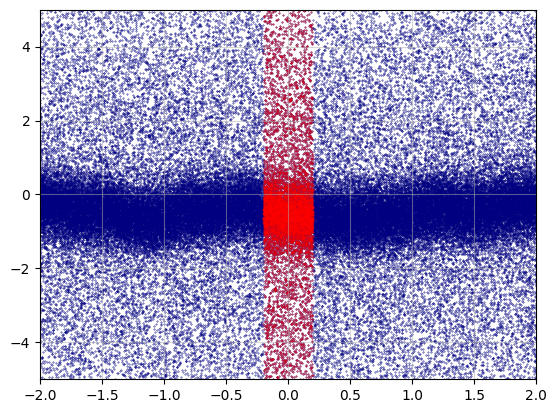

In [10]:
plt.scatter(X_cal[:,0], resid_tmp[:,0], s = 0.1, color ="navy", label = "sdf")
plt.scatter(X_cal[ABC_ind,0], resid_tmp[ABC_ind,0], s= 0.2, color = "red", alpha = 0.5, label="asdf")
#plt.scatter(X_cal[ABC_ind2,0], resid_tmp[ABC_ind2,0], s= 0.2, color = "red", alpha = 0.5)

plt.xlim([-2,2])
plt.ylim([-5,5])
plt.grid(True, alpha = 0.5)
#plt.legend("topright")

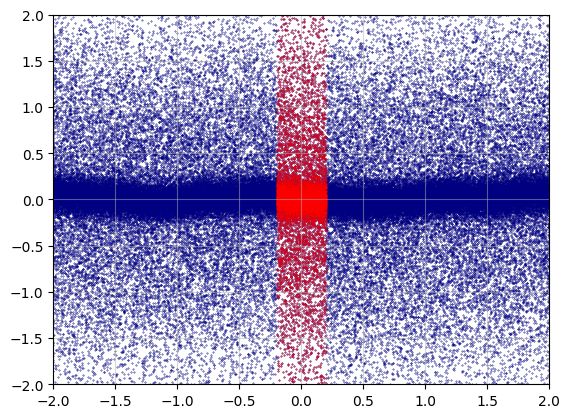

In [11]:
plt.scatter(X_cal[:,0], correct[:,0], s = 0.1, color = "navy")
plt.scatter(X_cal[ABC_ind,0], correct[ABC_ind,0], s= 0.2, color = "red", alpha = 0.5)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.grid(True, alpha = 0.5)

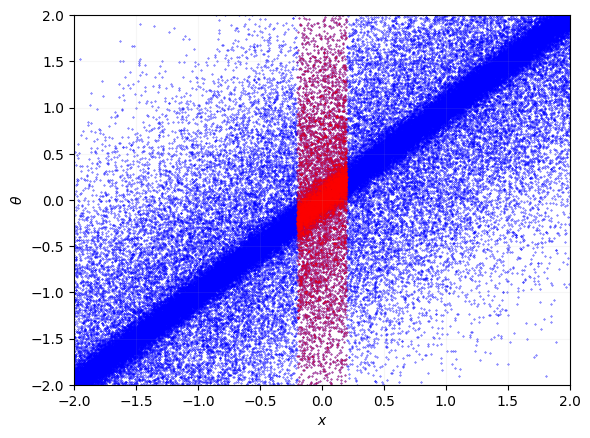

In [12]:
plt.scatter(X_cal[:,0], Y_cal[:,0], s=0.1, color = "blue")
plt.scatter(X_cal[ABC_ind,0], Y_cal[ABC_ind,0], s= 0.2, color = "red", alpha = 0.5)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel("$x$")
plt.ylabel(r"$\theta$")

plt.grid(True, alpha = 0.1)

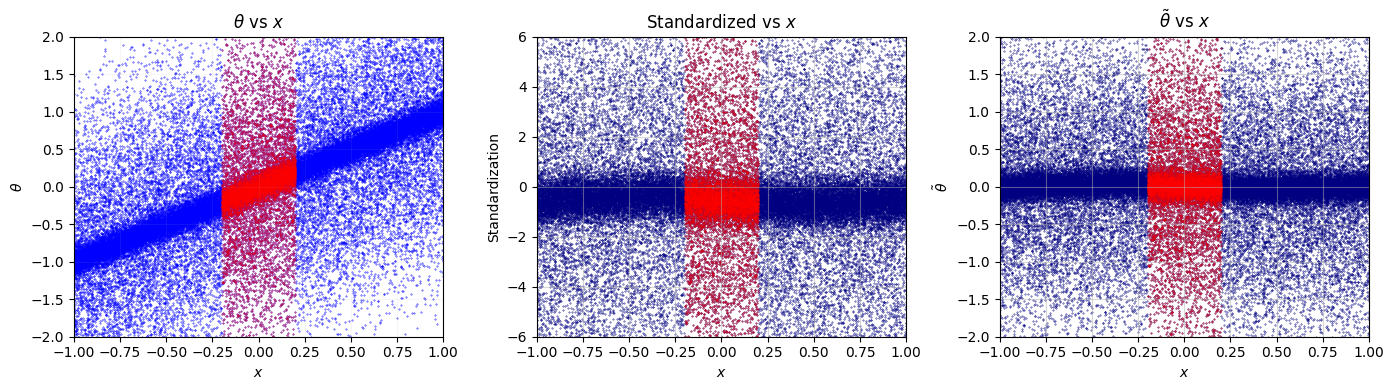

In [14]:
import matplotlib.pyplot as plt

# Create 1-row, 3-column layout
fig, axes = plt.subplots(1, 3, figsize=(14, 4))  # slightly wider for 3 plots

# --- Plot 1: Output vs Input ---
axes[0].scatter(X_cal[:, 0], Y_cal[:, 0], s=0.1, color="blue")
axes[0].scatter(X_cal[ABC_ind, 0], Y_cal[ABC_ind, 0], s=0.2, color="red", alpha=0.5)
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-2, 2])
axes[0].grid(True, alpha=0.1)
axes[0].set_title(r"$\theta$ vs $x$")
axes[0].set_xlabel("$x$")
axes[0].set_ylabel(r"$\theta$")

# --- Plot 2: Standardized residuals ---
axes[1].scatter(X_cal[:, 0], resid_tmp[:, 0], s=0.1, color="navy")
axes[1].scatter(X_cal[ABC_ind, 0], resid_tmp[ABC_ind, 0], s=0.2, color="red", alpha=0.5)
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-6, 6])
axes[1].grid(True, alpha=0.5)
axes[1].set_title("Standardized vs $x$")
axes[1].set_xlabel("$x$")
axes[1].set_ylabel("Standardization")

# --- Plot 3: Corrected (rescaled) theta ---
axes[2].scatter(X_cal[:, 0], correct[:, 0], s=0.1, color="navy")  # double check if this is intentional
axes[2].scatter(X_cal[ABC_ind, 0], correct[ABC_ind, 0], s=0.2, color="red", alpha=0.5)
axes[2].set_xlim([-1, 1])
axes[2].set_ylim([-2, 2])
axes[2].grid(True, alpha=0.5)
axes[2].set_title(r"$\tilde{\theta}$ vs $x$")
axes[2].set_xlabel("$x$")
axes[2].set_ylabel(r"$\tilde{\theta}$")

# Layout adjustment
plt.tight_layout()
plt.savefig("MoG_why.png", dpi=300, bbox_inches='tight')  # 300 is for publication
plt.show()


# ABC

In [15]:
x0 = torch.zeros((1,1))
true_sample = MoG_posterior(x0, n_samples = 10_000)

/home/hyun18/.conda/envs/NABC/lib/python3.11/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [16]:
torch.manual_seed(123589)
num_test = 100_000_000
Y_cal= priors.sample((num_test,))
X_cal = simulators(Y_cal)
ABC_ind = ABC_rej2(x0, X_cal, tol = 0.0001,device = device)


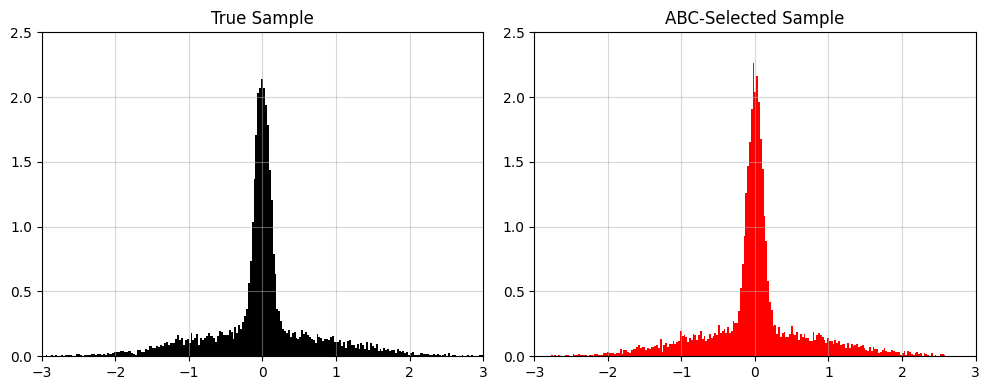

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# --- Left histogram: true sample ---
axes[0].hist(true_sample, bins=300, density=True, color="black")
axes[0].set_title("True Sample")
axes[0].grid(True, alpha=0.5)
axes[0].set_xlim([-3,3])
axes[0].set_ylim([0,2.5])

# --- Right histogram: ABC-selected sample ---
axes[1].hist(Y_cal[ABC_ind, :], bins=300, density=True, color="red")
axes[1].set_title("ABC-Selected Sample")
axes[1].grid(True, alpha=0.5)
axes[1].set_xlim([-3,3])
axes[1].set_ylim([0,2.5])


# Layout adjustment
plt.tight_layout()
plt.show()


# NABC

In [18]:
true_sample = MoG_posterior(x0, n_samples = 10_000)

In [19]:
torch.manual_seed(123589)
L = 1_000_000


Y_cal= priors.sample((L,))
X_cal = simulators(Y_cal)


# ABC_rej: need tol 0.001

In [20]:
tol_seq = np.arange(0.01, 0.1, 0.005)

In [21]:
tol_seq

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095])

## increase $\eta$

In [22]:
torch.manual_seed(1234)
np.random.seed(1234)
ABC_results = []
for j in range(10):
    ABC_results_0 = []
    for tol in tol_seq:
        ABC_ind = ABC_rej2(x0, X_cal, tol = tol,device = device)
        Y_test = Y_cal[ABC_ind,:]
        sam_ind_post = np.random.choice(np.arange(0, Y_test.size(0)), 10_000, replace = False)

        tmp = c2st(true_sample, Y_test[sam_ind_post,:])
        ABC_results_0.append(tmp[0].tolist())
        print("c2st", tmp, "j:", j)
    ABC_results.append(ABC_results_0)

c2st tensor([0.4931]) j: 0
c2st tensor([0.4937]) j: 0
c2st tensor([0.5495]) j: 0
c2st tensor([0.5771]) j: 0
c2st tensor([0.5911]) j: 0
c2st tensor([0.6112]) j: 0
c2st tensor([0.6199]) j: 0
c2st tensor([0.6295]) j: 0
c2st tensor([0.6419]) j: 0
c2st tensor([0.6458]) j: 0
c2st tensor([0.6546]) j: 0
c2st tensor([0.6564]) j: 0
c2st tensor([0.6690]) j: 0
c2st tensor([0.6676]) j: 0
c2st tensor([0.6733]) j: 0
c2st tensor([0.6803]) j: 0
c2st tensor([0.6835]) j: 0
c2st tensor([0.6773]) j: 0
c2st tensor([0.4922]) j: 1
c2st tensor([0.4912]) j: 1
c2st tensor([0.5415]) j: 1
c2st tensor([0.5741]) j: 1
c2st tensor([0.5946]) j: 1
c2st tensor([0.6116]) j: 1
c2st tensor([0.6173]) j: 1
c2st tensor([0.6306]) j: 1
c2st tensor([0.6402]) j: 1
c2st tensor([0.6500]) j: 1
c2st tensor([0.6511]) j: 1
c2st tensor([0.6579]) j: 1
c2st tensor([0.6630]) j: 1
c2st tensor([0.6654]) j: 1
c2st tensor([0.6742]) j: 1
c2st tensor([0.6805]) j: 1
c2st tensor([0.6751]) j: 1
c2st tensor([0.6817]) j: 1
c2st tensor([0.4925]) j: 2
c

In [24]:
torch.set_default_device("cpu")
x0 = torch.tensor([[0.0]])
net.eval()
net2.eval()
with torch.no_grad():
    resid_tmp = Y_cal - net(X_cal)
    sigma_tmp = torch.exp(net2(X_cal))
    resid_tmp = torch.clone(resid_tmp/sigma_tmp)
    sigma_x0 = torch.exp(net2(x0))
    mu_x0 = net(x0)
    correct = resid_tmp * sigma_x0 + mu_x0

In [25]:
torch.manual_seed(1234)
np.random.seed(1234)

NABC_results = []
for j in range(10):
    NABC_results_0 = []

    for tol in tol_seq:
        ABC_ind = ABC_rej2(x0, X_cal, tol = tol,device = device)
        Y_test = correct[ABC_ind,:]
        sam_ind_post = np.random.choice(np.arange(0, Y_test.size(0)), 10_000, replace = False)
        with torch.no_grad():
            tmp=c2st(true_sample, Y_test[sam_ind_post,:])
        NABC_results_0.append(tmp[0].tolist())
        print("c2st", tmp, "j:", j)
    NABC_results.append(NABC_results_0)

c2st tensor([0.4990]) j: 0
c2st tensor([0.4946]) j: 0
c2st tensor([0.4977]) j: 0
c2st tensor([0.5018]) j: 0
c2st tensor([0.5063]) j: 0
c2st tensor([0.5078]) j: 0
c2st tensor([0.5016]) j: 0
c2st tensor([0.5002]) j: 0
c2st tensor([0.5113]) j: 0
c2st tensor([0.5055]) j: 0
c2st tensor([0.5052]) j: 0
c2st tensor([0.5077]) j: 0
c2st tensor([0.5058]) j: 0
c2st tensor([0.5094]) j: 0
c2st tensor([0.5085]) j: 0
c2st tensor([0.5139]) j: 0
c2st tensor([0.5020]) j: 0
c2st tensor([0.4963]) j: 0
c2st tensor([0.4960]) j: 1
c2st tensor([0.5010]) j: 1
c2st tensor([0.4969]) j: 1
c2st tensor([0.5044]) j: 1
c2st tensor([0.5042]) j: 1
c2st tensor([0.5107]) j: 1
c2st tensor([0.4915]) j: 1
c2st tensor([0.5061]) j: 1
c2st tensor([0.5031]) j: 1
c2st tensor([0.5024]) j: 1
c2st tensor([0.5091]) j: 1
c2st tensor([0.4989]) j: 1
c2st tensor([0.5031]) j: 1
c2st tensor([0.4979]) j: 1
c2st tensor([0.5039]) j: 1
c2st tensor([0.5070]) j: 1
c2st tensor([0.5077]) j: 1
c2st tensor([0.5034]) j: 1
c2st tensor([0.5001]) j: 2
c

In [28]:
#torch.save(torch.tensor(ABC_results), "ABC_results.pt")
#torch.save(torch.tensor(NABC_results), "NABC_results.pt")


In [29]:
print(torch.mean(torch.tensor(ABC_results),0))
print(torch.mean(torch.tensor(NABC_results),0))

tensor([0.4919, 0.4928, 0.5363, 0.5744, 0.5924, 0.6078, 0.6194, 0.6303, 0.6421,
        0.6480, 0.6533, 0.6600, 0.6644, 0.6704, 0.6733, 0.6780, 0.6824, 0.6795])
tensor([0.4985, 0.4962, 0.4994, 0.5031, 0.5060, 0.5052, 0.5038, 0.5055, 0.5043,
        0.5027, 0.5044, 0.5014, 0.5002, 0.5017, 0.5023, 0.5053, 0.5017, 0.5044])


In [30]:
len(tol_seq)
len(ABC_results)

10

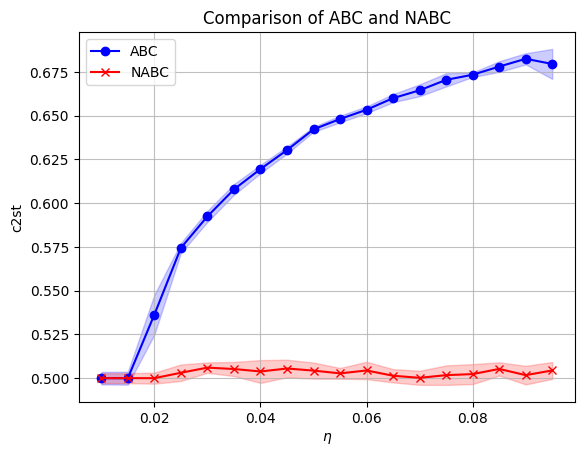

In [40]:
ABC_mean = torch.max(torch.mean(tmp1,0),torch.tensor(0.5))
ABC_std = torch.std(tmp1,0)

NABC_mean = torch.max(torch.mean(tmp2,0),torch.tensor(0.5))
NABC_std = torch.std(tmp2,0)

import matplotlib.pyplot as plt

plt.plot(tol_seq, ABC_mean, label="ABC", marker='o', color = "blue")
plt.plot(tol_seq, NABC_mean, label="NABC", marker='x', color = "red")

plt.fill_between(tol_seq, ABC_mean - ABC_std, ABC_mean + ABC_std, color='blue', alpha=0.2)
plt.fill_between(tol_seq, NABC_mean - NABC_std, NABC_mean + NABC_std, color='red', alpha=0.2)


plt.xlabel(r"$\eta$")
plt.ylabel("c2st")
plt.title("Comparison of ABC and NABC")
plt.grid(True,alpha = 0.8)
plt.legend()
plt.savefig("MoG_comparison.png", dpi=300, bbox_inches='tight')  # 300 is for publication

plt.show()
